# 案例分析(4) —— VTI 股价预测(LSTM)

# 1、股价预测 —— LSTM

## 1.1 LSTM

- Long Short-Term Memory 长短期记忆网络
- 是一种循环神经网络（RNN）
- 适合于处理和预测时间序列中间隔和延迟相对较长的重要事件

## 1.2 目标

- 使用长短期记忆（LSTM）预测下一天的股票价格
- 根据前 N 天的价格，预测 N+1 天的价格
- 数据集分成三份
    - train (60%)
    - dev (20%)
    - test (20%)

## 1.3 依赖库

#### (1) TensorFlow

- [官网](https://tensorflow.google.cn/)
- 基于数据流编程（dataflow programming）的符号数学系统
- 被广泛应用于各类机器学习（machine learning）算法的编程实现
- 在机器学习、深度学习领域有广泛应用
- 安装
    - 有 GPU / 有独立显卡
        - pip install tensorflow-gpu
    - 没有 GPU / 没有独立显卡 / 只有集成显卡
        - pip install tensorflow

#### (2) Keras

- 基于 Theano 和 TensorFlow 的深度学习库
- 高层神经网络 API
- 为支持快速实验而生，能够把你的 idea 迅速转换为结果
- 安装
    - pip install keras

#### (3) GraphViz

- 神经网络可视化
- 安装
    - ① pip install graphviz
    - ② 下载 [GraphViz 安装包](https://www.graphviz.org/download/)
        - 安装在除 C 盘外的其他盘（防止因为 Python 权限不够，不能调用）
        - 添加到环境变量（比如：右击“这台电脑”- 属性 - 高级系统设置 - 环境变量 - 点击系统变量中的 Path - 编辑 - 添加 "D:\softwares\Graphiz\bin"）
    - ③ pip install pydotplus
    - ④ 找到 Anaconda 的 keras 模块安装位置
        - 我的是 C:\Users\Degg\Anaconda3\Lib\site-packages\keras\utils
        - 用文本编辑器打开 vis_utils.py
        - 把里面的 pydot 都改成 pydotplus

## 1.4 导入模块

In [3]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from matplotlib import style
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from IPython.display import SVG
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [ ]:
# 出现No module named 'numpy.core._multiarray_umath'。这是在使用Tensorflow时出现的错误。
# numpy是一个基础的数组计算包，Tensorflow、 tensorboard、Keras-Preprocessing、h5py、pandas等一系列常用的第三方库都需要numpy的支持。
# 这里提示numpy.core._multiarray_umath failed to import和numpy.core.umath failed to import ，
# 得知无法正常import tensorflow 的原因是numpy库的引用出了问题。应该是numpy版本和当前Tensorflow版本兼容性问题。
# 解决方法：
# 方法一：
# pip install --user --upgrade numpy   #将numpy更新到最新版本
# pip install numpy==1.16  #这个好用！！

## 1.5 设置参数

In [4]:
#### Input params ##################
stk_path = "./VTI.csv"
test_size = 0.2                # 交叉验证集 (cross-validation set) 占总数据集 (dataset) 的比例
cv_size = 0.2                  # 测试集 (test set) 占总数据集的比例

N = 9                          # 对于第 t 天，以滞后 t-1, t-2, ..., t-N 作为特征
                               # 初始值，后续会调参（tuning）
lstm_units = 50                # LSTM 初始参数：单元个数
dropout_prob = 1               # LSTM 初始参数：dropout（随机失活），用于解决深度神经网络中的过拟合或梯度消失问题
optimizer = 'adam'             # LSTM 初始参数：Adam —— 优化器的一种
epochs = 1                     # LSTM 初始参数：训练的轮次
batch_size = 1                 # LSTM 初始参数：每次训练的样本个数

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# 设置随机种子，从而确保每次得到相同的结果
seed(101)
set_random_seed(model_seed)

## 1.6 通用函数

#### (1) 计算平均绝对百分比误差

In [5]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### (2) 建立数据集

In [7]:
def get_x_y(data, N, offset):
    """
    把数据分成 x（特征）和 y（目标）
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

#### (3) 特征归一化

In [8]:
def get_x_scaled_y(data, N, offset):
    """
    把数据分成 x（特征）和 y（目标）
    把 x 进行归一化，即均值为 0，标准差为 1
    不对 y 进行归一化
    输入：
        data     : pandas 序列
        N        : N 组数据
        offset   : 序列从 offset 之后的值 开始作为目标
    输出：
        x_scaled : 归一化后的特征 x
        y        : 未归一化的目标值
        mu_list  : 存储均值的列表，与 x_scaled 和 y 长度相同
        std_list : 存储标准差的列表，与 x_scaled 和 y 长度相同
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i] - mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

#### (4) 训练 · 预测 · 评估模型

In [9]:
def train_pred_eval_model(x_train_scaled,
                          y_train_scaled,
                          x_cv_scaled,
                          y_cv,
                          mu_cv_list,
                          std_cv_list,
                          lstm_units=50,
                          dropout_prob=0.5,
                          optimizer='adam',
                          epochs=1,
                          batch_size=1):
    '''
    功能：
        训练模型，进行预测，缩放回原始，评估模型
        使用 LSTM
        返回 RMSE，MAPE 和 预测值
    输入：
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). 我们使用过去 9 个值来预测下一个值
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : 验证集，用于做预测
        y_cv            : 验证集，实际值
        mu_cv_list      : 存储均值的列表，与 x_scaled 和 y 长度相同
        std_cv_list     : 存储标准差的列表，与 x_scaled 和 y 长度相同
        lstm_units      : LSTM 参数
        dropout_prob    : LSTM 参数
        optimizer       : LSTM 参数
        epochs          : LSTM 参数
        batch_size      : LSTM 参数
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        y_cv_pred       : predictions
    '''
    # 创建 LSTM 网络
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob))  # 添加 dropout，概率为 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))  # 添加 dropout，概率为 0.5
    model.add(Dense(1))

    # 训练 LSTM 网络
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # 预测
    y_cv_pred_scaled = model.predict(x_cv_scaled)
    y_cv_pred = (y_cv_pred_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # 计算 RMSE 和 MAPE
    rmse = math.sqrt(mean_squared_error(y_cv, y_cv_pred))
    mape = get_mape(y_cv, y_cv_pred)
    
    return rmse, mape, y_cv_pred

## 1.7 导入数据

#### (1) 导入并简单处理

In [10]:
df = pd.read_csv(stk_path, sep = ",")

# 把第一列的 Date 转换成 datetime 对象
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# 把所有列名转成小写，并把空格替换成下划线  比如 Date -> date , Adj Close -> adj_close
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# 加一列：月份列
df['month'] = df['date'].dt.month

# 根据 datetime 进行升序排序，原地排序
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,high,low,open,close,volume,adj_close,month
0,2015-11-24,107.589996,106.309998,106.570000,107.389999,2032600.0,100.287285,11
1,2015-11-25,107.660004,107.250000,107.510002,107.470001,1820300.0,100.361992,11
2,2015-11-27,107.760002,107.220001,107.589996,107.629997,552400.0,100.511406,11
3,2015-11-30,107.849998,107.110001,107.779999,107.169998,3618100.0,100.081833,11
4,2015-12-01,108.209999,107.370003,107.589996,108.180000,2443600.0,101.025032,12


#### (2) 绘制adjusted close随时间变化曲线

In [11]:
style.use('ggplot')

Text(0,0.5,'USD')

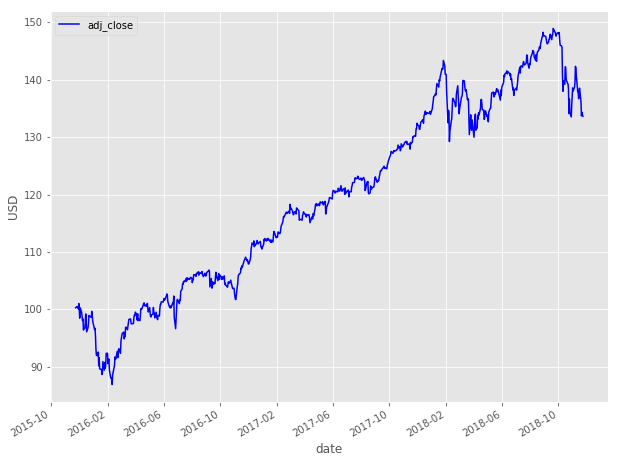

In [12]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

## 1.8 将数据集分成训练集、验证集、测试集

#### (1) 获取各个集的大小

In [13]:
# Get sizes of each of the datasets

num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 454
num_cv = 151
num_test = 151


#### (2) 数据集的分割
- 时间序列
- 只需要日期和收盘价

In [14]:
# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (454, 2)
cv.shape = (151, 2)
train_cv.shape = (605, 2)
test.shape = (151, 2)


#### (3) 训练集

In [15]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 9, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [107.85530771]
scaler.var_ = [93.00280891]
x_train_scaled.shape = (445, 9, 1)
y_train_scaled.shape = (445, 1)


#### (4) 验证集

In [16]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (151, 9, 1)
y_cv.shape = (151, 1)
len(mu_cv_list) = 151
len(std_cv_list) = 151


#### (5) 训练+验证集

In [17]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [114.0696099]
scaler_final.var_ = [191.42353549]


## 1.9 训练 LSTM 网络

#### (1) 搭建网络

In [18]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 8s - loss: 0.0609


#### (2) 打印模型 summary

In [19]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### (3) 模型结构可视化显示，并输出到文件

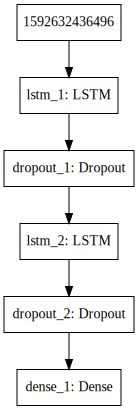

In [20]:
plot_model(model, to_file='model_lstm.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 1.10 在验证集上预测

#### (1) 作预测

In [21]:
# Do prediction
y_cv_pred_scaled = model.predict(x_cv_scaled)
y_cv_pred = (y_cv_pred_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("y_cv_pred.shape = " + str(y_cv_pred.shape))

y_cv_pred.shape = (151, 1)


#### (2) 计算 RMSE

- RMSE before tuning: 调参之前的 RMSE

In [22]:
# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, y_cv_pred))
print("RMSE = %0.3f" % rmse_bef_tuning)

RMSE = 2.193


#### (3) 计算 MAPE

- MAPE percent before tuning: 调参之前的 MAPE

In [23]:
# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, y_cv_pred)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

MAPE = 1.141%


#### (4) 绘图

Text(0,0.5,'USD')

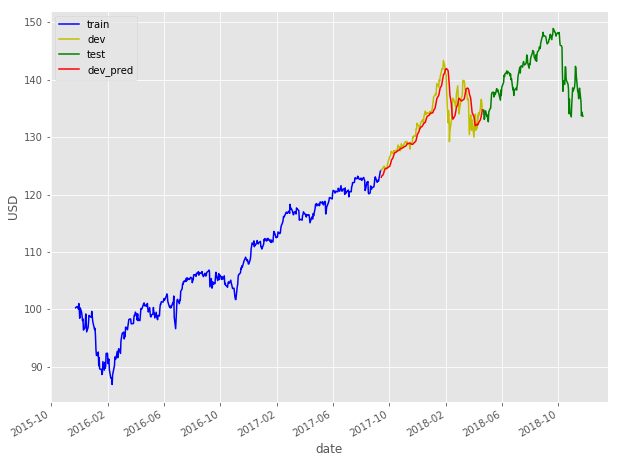

In [24]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

pred_df = pd.DataFrame({'y_cv_pred': y_cv_pred.reshape(-1),   # reshape(-1)  把维度从 (151, 1) 调成 (151, )
                        'y_cv': y_cv.reshape(-1),
                        'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = pred_df.plot(x='date', y='y_cv_pred', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'dev_pred'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

## 1.11 调参：N (用于特征的天数)

- Tuning N (no. of days to use as features)

#### (1) 参数名及调节范围

In [25]:
param_label = 'N'
param_list = range(3, 40)

#### (2) 调参过程

- 对 N 的每个取值均训练模型，计算误差
    - for 循环
        - tqdm_notebook  可以显示循环的进度条
        - 其他参数仍采用初始值
    - 放到 DataFrame 中最后做评判
- 用 time.time() 方法计算总耗时

In [26]:
error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer=optimizer,
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   
#用了15min-21min。god！！！！！


Minutes taken = 21.944574276606243


,N,rmse,mape_pct
0,3,1.564962,0.801336
1,4,1.723903,0.904151
2,5,1.924790,0.997140
3,6,1.975940,1.011391
4,7,2.077949,1.070619
5,8,2.062424,1.083095
6,9,2.170790,1.132971
7,10,2.188010,1.146563
8,11,2.203432,1.174737
9,12,2.207881,1.156050


#### (3) 画误差曲线

Text(0,0.5,'RMSE/MAPE(%)')

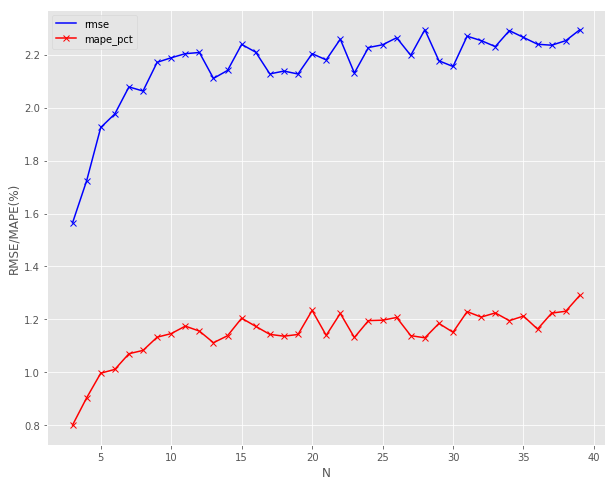

In [27]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

<img src="images/1001.png">

#### (4) 获取参数的最佳值

In [28]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]

print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 1.565
min MAPE = 0.801%
optimum N = 3


## 1.12 调参：epochs 和 batch_size
- Tuning model - epochs and batch_size

- 采用上步得到的 N_opt = 3
- epochs: 训练的轮次
- batch_size: 每次训练的样本个数

#### (1) 调参过程

In [32]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()

for param in tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv,
                                              mu_cv_list,
                                              std_cv_list,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer=optimizer,
                                              epochs=param,
                                              batch_size=param2)
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   
# 预计时间：34分钟，god！！！


Minutes taken = 34.427841782569885


,epochs,batch_size,rmse,mape_pct
0,1,8,1.590597,0.814574
1,1,16,1.467380,0.742603
2,1,32,1.414628,0.713196
3,1,64,1.400080,0.707323
4,1,128,1.391447,0.702278
5,10,8,1.546856,0.788774
6,10,16,1.556902,0.792922
7,10,32,1.575920,0.804873
8,10,64,1.574628,0.803502
9,10,128,1.593253,0.816068


#### (2) 画误差曲线

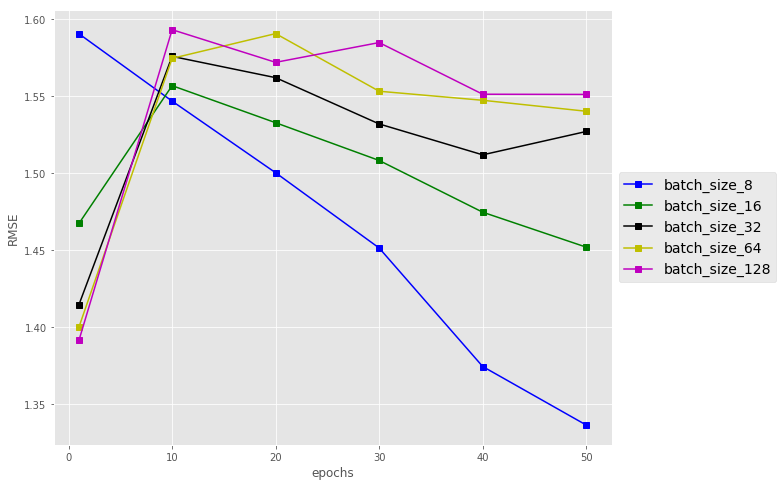

In [33]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

<img src="images/1002.png">

#### (3) 获取参数的最佳值

In [34]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]

print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 1.336
min MAPE = 0.666%
optimum epochs = 50
optimum batch_size = 8


## 1.13 调参：LSTM 单元数 和 随机失活概率


- Tuning model - LSTM units and dropout prob

#### (1) 调参过程

In [35]:
param_label = 'lstm_units'
#param_list = [10, 50, 64, 128]  #太慢了
param_list = [10, 50]  #演示用取2个

param2_label = 'dropout_prob'
#param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1] #太慢了
param2_list = [0.5, 0.8] #太慢了

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv,
                                              mu_cv_list,
                                              std_cv_list,
                                              lstm_units=param,
                                              dropout_prob=param2,
                                              optimizer=optimizer,
                                              epochs=epochs_opt,
                                              batch_size=batch_size_opt)
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   
# take a long time of about 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Minutes taken = 11.499744085470835


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,1.540964,0.779882
1,10,0.8,1.542868,0.780480
2,50,0.5,1.454066,0.731615
3,50,0.8,1.517235,0.770733


#### (2) 画误差曲线

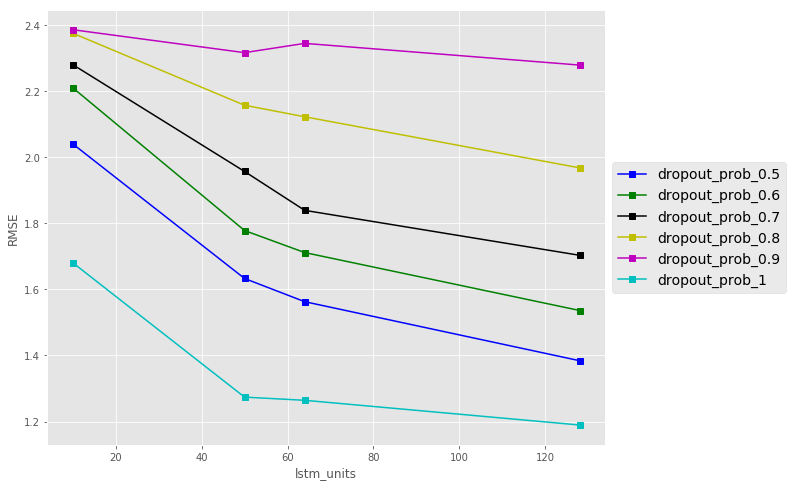

In [26]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

<img src="images/1003.png">

#### (3) 获取参数的最佳值

In [36]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 1.454
min MAPE = 0.732%
optimum lstm_units = 50
optimum dropout_prob = 0.5


## 1.14 调参：优化器
- Tuning model - optimizer

#### (1) 调参过程

In [37]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=lstm_units_opt,
                                          dropout_prob=dropout_prob_opt,
                                          optimizer=param,
                                          epochs=epochs_opt,
                                          batch_size=batch_size_opt)
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate
# 用时19分钟！！！！！！！！！！！！！！！


Minutes taken = 19.022441160678863


,optimizer,rmse,mape_pct
0,adam,1.473421,0.747054
1,sgd,1.475573,0.744344
2,rmsprop,1.477367,0.749566
3,adagrad,1.528305,0.775285
4,adadelta,1.461144,0.741002
5,adamax,1.513583,0.770153
6,nadam,1.421567,0.709065


#### (2) 画误差曲线

Text(0, 0.5, 'RMSE/MAPE(%)')

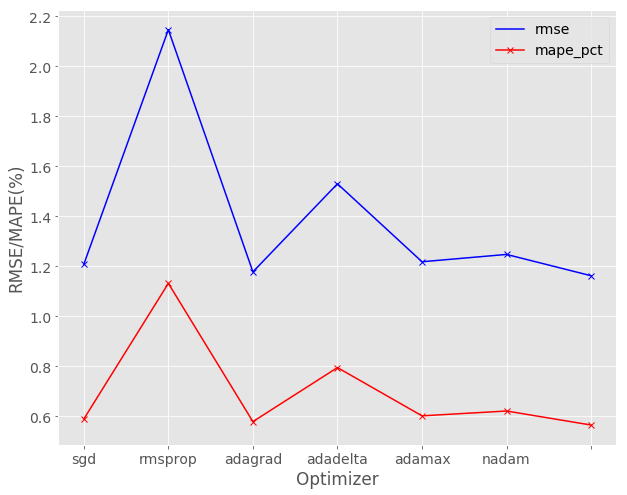

In [29]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

<img src="images/1004.png">

#### (3) 获取参数的最佳值

In [42]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 1.422
min MAPE = 0.709%
optimum optimizer = nadam


## 1.15 调试后的参数

In [43]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,3
1,lstm_units,50,50
2,dropout_prob,1,0.5
3,optimizer,adam,nadam
4,epochs,1,50
5,batch_size,1,8
6,rmse,2.19317,1.42157
7,mape_pct,1.14058,0.709065


## 1.16 最终模型

#### (1) 训练

In [44]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled,
                                        y_train_cv_scaled,
                                        x_test_scaled,
                                        y_test,
                                        mu_test_list,
                                        std_test_list,
                                        lstm_units=lstm_units_opt,
                                        dropout_prob=dropout_prob_opt,
                                        optimizer=optimizer_opt,
                                        epochs=epochs_opt,
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)
#22:28-?

RMSE on test set = 1.506
MAPE on test set = 0.775%


#### (2) 绘制收盘价随时间变化曲线

Text(0,0.5,'USD')

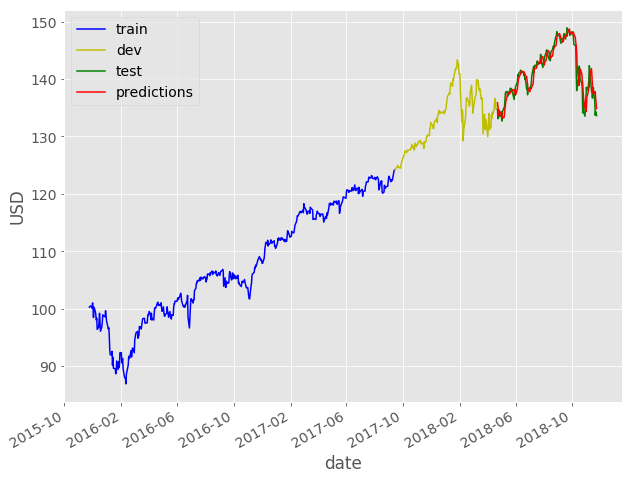

In [45]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

<img src="images/1005.png">

#### (3) 放大特定区间

NameError: name 'est_df' is not defined

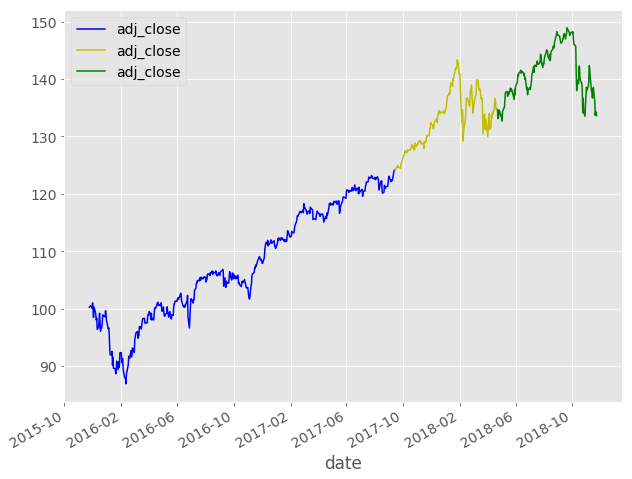

In [38]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

<img src="images/1006.png">

#### (4) 放大测试集部分

(130, 155)

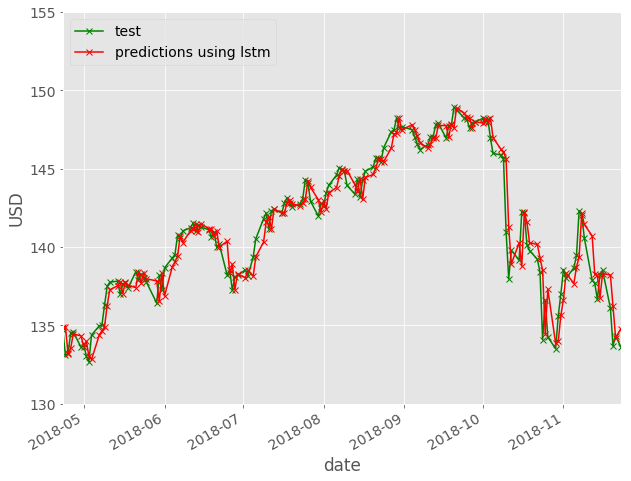

In [39]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])

<img src="images/1007.png">

#### (5) 保存

In [40]:
# Save as csv
test_lstm = est_df
test_lstm.to_csv("./test_lstm.csv")

## 案例分析(4) 结束